# Imports
pytorch and other relevant libs

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

GPU instead of CPU if available

In [50]:

# Device and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

# CNN class
consists of the forward propagation function that has 3 total convolutions which are controlled by a ReLU function and pooled after every iteration

In [51]:

# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(torch.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(torch.relu(self.conv3(x)))  # 8x8 -> 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Load and save
2 functions that prevent the user from training the model each time they would like to use it, especially since cnns take longer than normal nn's

In [52]:
# Simple checkpoint save
def save_model(model, optimizer, epoch, losses, accuracies):
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'losses': losses,
        'accuracies': accuracies
    }, 'checkpoint.pth')


In [53]:
# Simple checkpoint load
def load_model(model, optimizer):
    if os.path.exists('/content/checkpoint.pth'):
        checkpoint = torch.load('/content/checkpoint.pth', map_location=device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"Resumed from epoch {checkpoint['epoch']}")
        return checkpoint['epoch'], checkpoint['losses'], checkpoint['accuracies']
    else:
        print("Starting fresh")
        return 0, [], []

In [54]:
# Data loading
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

#EDA
shows the number of images in training / testing,

 as well as all the classes
and the image dimensions



In [55]:

import random

# Show 10 random samples
print("Dataset info:")
print(f"Training: {len(trainset)} images")
print(f"Test: {len(testset)} images")
print(f"Classes: {classes}")
print(f"Image size: 32x32x3 (tiny!)")


Dataset info:
Training: 50000 images
Test: 10000 images
Classes: ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image size: 32x32x3 (tiny!)


# Object initialization
intializting object from CNN class and setting up the optimizer for updating weights as well as crossentropyloss to calculate the losee

In [56]:
# Model setup
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

If model is pretrained no new training is needed thus the old model is loaded

In [57]:

start_epoch, losses, accuracies = load_model(model, optimizer)

Resumed from epoch 29


# Training loop
start from the current epochs to the specified epoch, curreny epoch may not be 0 due to loading previously trained model,
the steps are as follows:



1.   remove any gradient bias
2.   use forward function
3.   calculate the loss
4.   propagate backwards
5.   finally update the weights


   
    

In [58]:
# Training
num_epochs = 30

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    train_acc = 100 * correct / total
    avg_loss = running_loss / len(trainloader)

    # Test accuracy every few epochs
    # Check test accuracy every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        test_acc = 100 * correct / total
        print(f"[{epoch+1}] train acc: {train_acc:.1f}% | test acc: {test_acc:.1f}% | loss: {avg_loss:.3f}")
    else:
        print(f"[{epoch+1}] train acc: {train_acc:.1f}% | loss: {avg_loss:.3f}")

    # Store metrics
    losses.append(avg_loss)
    accuracies.append(train_acc)

    # Save every 5 epochs
    if epoch % 5 == 0:
        save_model(model, optimizer, epoch, losses, accuracies)

[30] train acc: 91.3% | loss: 0.240


Now the final accuracy is calculated

In [59]:
# Final test
print("\nFinal Testing...")
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.1f}%")


Final Testing...
Final Test Accuracy: 78.1%


The new training weights are saved

In [60]:
# Save final model
save_model(model, optimizer, num_epochs-1, losses, accuracies)

#Plotting
Training loss is plotted as well as accuracy to show the overtime progression and asymptotes

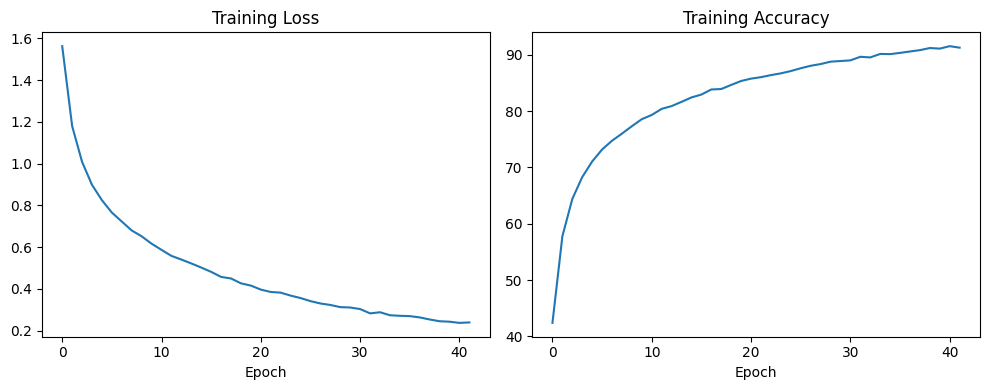

In [61]:
# plot
if losses:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

# Confusion Matrix
using sklearn libraries confusion matrix to show correct and incorrect predictions visually

<Figure size 800x600 with 0 Axes>

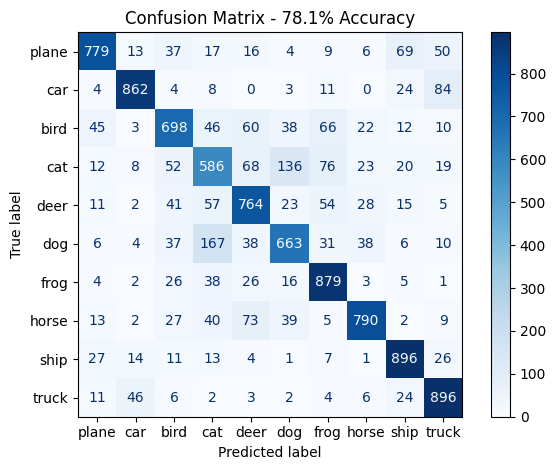

Model saved to checkpoint.pth


In [62]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues')
plt.title(f'Confusion Matrix - {test_acc:.1f}% Accuracy')
plt.tight_layout()
plt.show()

print("Model saved to checkpoint.pth")